In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [5]:
df = pd.read_csv("../ready_data/winter_2021.csv", index_col="ts")
# Drop columns which we are not able to get via weather forecast API
#test_df = pd.read_csv("../ready_data/test_day.csv", index_col="timestamp")


In [6]:
# initialize DF for saving metrics
metrics_df = pd.DataFrame({
    'Metric': ['Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R-squared']})

1. Get the weather forecast data for next two hours. 

In order to imitate this, calculate the average temperature, humidity, dewpoint and precipitation for next two hours.

In [7]:
def calculate_forecast(df, columns):
    for col in columns:
        df[f"fcst_{col}"] = df[col][::-1].rolling(window=12, min_periods=1).mean()[::-1]
    return df



In [8]:
# Leave road surface temperature and water film data out, because such data is only obtainable from sensor and can not be parsed from weather API.
# In future, to possibly improve the accuracy, they can be forecasted with another model
forecast_columns = ['airTemp', 'humidity', 'dewpoint', 'precipitation']

In [9]:
df = calculate_forecast(df, forecast_columns)

2. Get average of weather data for previous 4 hours to help model to generalize 

In [10]:
def calculate_avg_past(df, columns):
    for col in columns:
        df[f"past4h_avg_{col}"] = df[col].rolling(window=24, min_periods=1).mean()
    return df

In [11]:
past4h_avg_columns = ['airTemp', 'humidity', 'dewpoint', 'precipitation', 'Friction',
       'Road_Surface_Temperature', 'Water_Film_Surface_mm']

In [12]:
df = calculate_avg_past(df, past4h_avg_columns)

3. Shift friction to 2 hours back, so we get friction forecast based on histroical data

In [13]:
# Shift target variable for 12 time steps
def add_target(df):
    df['friction_fcst'] = df['Friction'].shift(periods=-12)
    df = df.dropna()
    return df

In [14]:
df = add_target(df)


In [15]:
# if you  have more than one independent variables, list them all here
# leave out the target variable! (dependent variable)
X = df.drop(["friction_fcst"], axis=1)

# have only the target variable here (dependent variable)
y = df['friction_fcst']

In [16]:
# create train and test sets of your dataset
# random_state is optional, you can lock this down in order to 
# to get same results always
# this examples reserves 30% for test data, 70% for training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

<h1>XGB</h1>

In [17]:
xgb_model = XGBRegressor(random_state=101)
xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)

mse = round(metrics.mean_squared_error(y_test, predictions), 2)
rmse = round(metrics.mean_squared_error(y_test, predictions, squared=False), 2)
mae = round(metrics.mean_absolute_error(y_test, predictions), 2)
r2 = round(metrics.r2_score(y_test, predictions), 2)

metrics_df["XGB"] = [mse, rmse, mae, r2]

metrics_df

c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Metric,XGB
0,Mean Squared Error,0.00
1,Root Mean Squared Error,0.03
2,Mean Absolute Error,0.02
3,R-squared,0.97


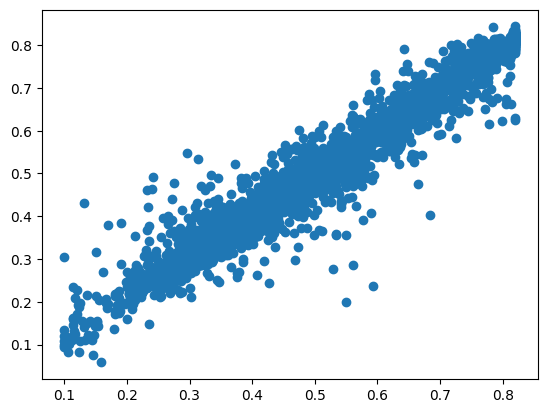

In [18]:
plt.scatter(y_test, predictions)
plt.show()

In [19]:
test_df = pd.read_csv("../ready_data/test_day.csv", index_col="ts")
test_df = calculate_forecast(test_df, forecast_columns)
test_df = calculate_avg_past(test_df, past4h_avg_columns)
test_df = add_target(test_df)
test = test_df.drop("friction_fcst", axis=1)

In [34]:
result =  xgb_model.predict(test)
result

array([0.4631407 , 0.4585205 , 0.45482844, 0.44951373, 0.44951373,
       0.4520742 , 0.4520742 , 0.4583471 , 0.4520742 , 0.45872456,
       0.45833567, 0.44901022, 0.4495023 , 0.45833567, 0.45179853,
       0.45786944, 0.4584907 , 0.4584907 , 0.45377642, 0.45377642,
       0.48399836, 0.47848687, 0.47720882, 0.47828817, 0.4819143 ,
       0.4910372 , 0.48784506, 0.4740202 , 0.4740202 , 0.4740202 ,
       0.4725952 , 0.46641093, 0.46641093, 0.46064162, 0.46593225,
       0.46997944, 0.46338993, 0.4663318 , 0.46160886, 0.46226454,
       0.4587543 , 0.45548517, 0.441686  , 0.44232818, 0.441686  ,
       0.44198614, 0.44198614, 0.45872405, 0.46628717, 0.46447384,
       0.45984045, 0.45984045, 0.43509895, 0.43509895, 0.43860918,
       0.43860918, 0.43860918, 0.44906077, 0.44976845, 0.45406494,
       0.46474057, 0.47131488, 0.5047565 , 0.51876837, 0.52074105,
       0.5259304 , 0.53404135, 0.53793466, 0.531655  , 0.5196357 ,
       0.52149004, 0.52149004, 0.51932895, 0.51932895, 0.51988

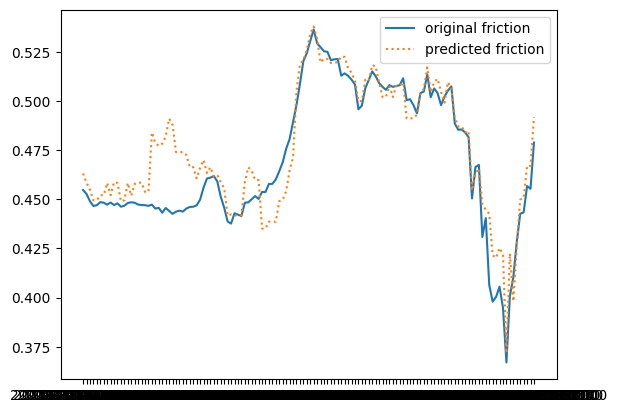

In [39]:
plt.plot(test.index, test.Friction, label="original friction")
plt.plot(test.index, result, linestyle = ":", label="predicted friction")
plt.legend()
plt.show()

<h1>XGB and Optuna</h1>

In [40]:
# 1. Wrap model training with an objective function and return accuracy
def objective(trial):
    # Suggest values of the hyperparameters using a trial object.
    # Check model's (!!! not the optuna) documentation to find out possible parameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_jobs': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    # Model
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    # Wanted metric to optimize
    rmse = metrics.mean_squared_error(y_test, predictions, squared=False)
    return rmse

In [41]:
# Create a study object and optimize the objective function.
# Directions: minimize and maximize; Trials are smth similar to epochs.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Save best hyperparameters into variable
best_params = study.best_params
# Final model with best parameters
final_model = XGBRegressor(**best_params, random_state=101)
final_model.fit(X_train, y_train)

predictions = final_model.predict(X_test)

# Add new metrics to metrics df
mse = round(metrics.mean_squared_error(y_test, predictions), 2)
rmse = round(metrics.mean_squared_error(y_test, predictions, squared=False), 2)
mae = round(metrics.mean_absolute_error(y_test, predictions), 2)
r2 = round(metrics.r2_score(y_test, predictions), 2)

metrics_df['XGB Optuna'] = [mse, rmse, mae, r2]
metrics_df

[I 2024-12-02 15:57:35,014] A new study created in memory with name: no-name-0a66c27c-372d-4358-bb50-3851428a4178
c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-02 15:57:39,906] Trial 0 finished with value: 0.04412636139840419 and parameters: {'learning_rate': 0.27897272064119255, 'n_estimators': 475, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.9295458466080839, 'colsample_bytree': 0.7267502966286581, 'gamma': 0.17534439080810915, 'reg_alpha': 0.7653350268128026, 'reg_lambda': 0.14187756675380592}. Best is trial 0 with value: 0.04412636139840419.
c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. 

,Metric,XGB,XGB Optuna
0,Mean Squared Error,0.00,0.00
1,Root Mean Squared Error,0.03,0.03
2,Mean Absolute Error,0.02,0.01
3,R-squared,0.97,0.98


In [44]:
final_model.save_model("xgb_best.json")

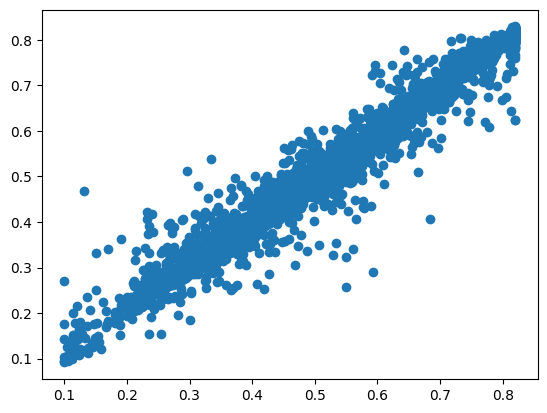

In [42]:
plt.scatter(y_test, predictions)
plt.show()